In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bitalg.visualizer.main import Visualizer


In [9]:
from numpy.random import uniform

In [2]:
BLUE = u'#1f77b4'
ORANGE = u'#ff7f0e'
GREEN = u'#2ca02c'
RED = u'#d62728'
PURPLE = u'#9467bd'

In [3]:
def generate_uniform_points(left, right, n = 10 ** 5):
    x = np.float64(np.random.uniform(low=left, high=right, size=n))
    y = np.float64(np.random.uniform(low=left, high=right, size=n))
    return list(zip(x, y))

In [15]:
def create_uniform(bound_x, bound_y, point_count=100):

    UNIFORM = [(uniform(*bound_x), uniform(*bound_y)) for _ in range(point_count)]
    return UNIFORM

In [21]:
p = create_uniform(10,6,point_count=10)
p


[(7.291352896265935, 5.2352022989946985),
 (5.499803658358996, 5.412973738166944),
 (3.3165769853688287, 3.15279502083711),
 (1.240891979941395, 2.756092201567934),
 (9.045426144056906, 2.41748619417422),
 (6.363851012379669, 3.1858318460731585),
 (1.4956804754446917, 2.78055203346221),
 (2.755761876495396, 4.202477491137874),
 (3.2466162649441994, 3.4136039701707923),
 (4.312991903658244, 5.994500517685351)]

In [24]:
points = generate_uniform_points(0, 10, 15)

In [28]:
def create_bounds_points(bound_x, bound_y, point_count=100):
    left = [(bound_x[0], uniform(*bound_y)) for _ in range(point_count // 4)]
    right = [(bound_x[1], uniform(*bound_y)) for _ in range(point_count // 4)]
    top = [(uniform(*bound_x), bound_y[0]) for _ in range(point_count // 4)]
    bot = [(uniform(*bound_x), bound_y[1]) for _ in range(point_count // 4)]

    return top + left + right + bot

In [29]:
def create_bounds_points(bound_x, bound_y, point_count=100):
    left = [(bound_x[0], uniform(*bound_y)) for _ in range(point_count // 4)]
    right = [(bound_x[1], uniform(*bound_y)) for _ in range(point_count // 4)]
    top = [(uniform(*bound_x), bound_y[0]) for _ in range(point_count // 4)]
    bot = [(uniform(*bound_x), bound_y[1]) for _ in range(point_count // 4)]

    return top + left + right + bot


def create_edge_cluster(max_x, max_y, bound_x, bound_y, point_count=100):
    edges = [(0, max_y), (max_x, max_y), (max_x, 0)]
    points = [(uniform(*bound_x), uniform(*bound_y)) for _ in range(point_count)]
    return points + edges

In [39]:
UNIFORM = [create_uniform((0, 1000), (0, 1000), 1000 * (i + 1)) for i in range(10)]
UNIFORM_REGION = 200, 200, 500, 500
BOUND = [create_bounds_points((5, 1000), (5, 1000), 1000 * (i + 1)) for i in range(10)]
BOUND_REGION = 0, 0, 800, 800
EDGE = [create_edge_cluster(1000, 1000, (0, 10), (0, 10), 10 * i) for i in range(5)]
EDGE_REGION = 0, 0, 100, 100

In [25]:
Point = tuple[float, float]
Line = tuple[Point, Point]

class Interval:
    def __init__(self, left: float, right: float):
        self.left: float = left
        self.right: float = right

    def __contains__(self, item: float) -> bool:
        return self.left <= item <= self.right

    def mid(self): 
        return 0.5*(self.left + self.right)

    def lower_half(self):
        return Interval(self.left, self.mid())

    def upper_half(self):
        return Interval(self.mid(), self.right)

    def __str__(self):
        return f"[{self.left:.2f}, {self.right:.2f}]"

    def intersects(self, other: "Interval") -> bool:
        return self.right in other or other.right in self

class Rectangle:
    def __init__(self, intervalx, intervaly):
        self.intervalx: Interval = intervalx
        self.intervaly: Interval = intervaly

    def __contains__(self, item: Point) -> bool:
        return item[0] in self.intervalx and item[1] in self.intervaly

    def __str__(self):
        return f"{self.intervalx}x{self.intervaly}"

    @classmethod 
    def boundary(cls, points: list[Point]) -> "Rectangle":
        minx = min(x for x, y in points)
        maxy = max(y for x, y in points)
        miny = min(y for x, y in points)
        maxx = max(x for x, y in points)
        return cls(Interval(minx, maxx),Interval(miny, maxy))

    @classmethod
    def from_tuples(cls, xs: tuple[float, float], ys: tuple[float, float]) -> "Rectangle":
        return cls(Interval(xs[0], xs[1]), Interval(ys[0], ys[1]))

    def NE(self):
        return Rectangle(self.intervalx.upper_half(), self.intervaly.upper_half())

    def NW(self):
        return Rectangle(self.intervalx.lower_half(), self.intervaly.upper_half())

    def SW(self):
        return Rectangle(self.intervalx.lower_half(), self.intervaly.lower_half())
        
    def SE(self):
        return Rectangle(self.intervalx.upper_half(), self.intervaly.lower_half())

    def intersects(self, other: "Rectangle") -> bool:
        return self.intervalx.intersects(other.intervalx) and self.intervaly.intersects(other.intervaly)
        
    def vertices(self) -> list[Point]:
        NE = (self.intervalx.right, self.intervaly.right)
        NW = (self.intervalx.left, self.intervaly.right)
        SW = (self.intervalx.left, self.intervaly.left)
        SE = (self.intervalx.right, self.intervaly.left)
        return [NE, NW, SW, SE]

    def edges(self) -> list[Line]:
        NE, NW, SW, SE = self.vertices()
        return [(NE, NW),
                (NW, SW),
                (SW, SE),
                (SE, NE)
               ]
        


class Node:
    def __init__(self, rect, points, parent=None):
        self.rect = rect
        self.points = points
        self.parent = parent
        self.NE = None
        self.NW = None
        self.SW = None
        self.SE = None

    def _divide(self):
        xmid = self.rect.intervalx.mid()
        ymid = self.rect.intervaly.mid()
        PNE = [p for p in self.points if p[0] > xmid and p[1] > ymid]
        PNW = [p for p in self.points if p[0] <= xmid and p[1] > ymid]
        PSW = [p for p in self.points if p[0] <= xmid and p[1] <= ymid]
        PSE = [p for p in self.points if p[0] > xmid and p[1] <= ymid]

        self.NE = Node(self.rect.NE(), PNE, self)
        self.NW = Node(self.rect.NW(), PNW, self)
        self.SW = Node(self.rect.SW(), PSW, self)
        self.SE = Node(self.rect.SE(), PSE, self)
        self.points = None
    
    def _divide_recursively(self):
        if len(self.points) < 2:
            return
        self._divide()

        self.NE._divide_recursively()
        self.NW._divide_recursively()
        self.SW._divide_recursively()
        self.SE._divide_recursively()

    def __str__(self):
        return f"Node({self.rect}, {self.points})"

    def is_leaf(self):
        return self.NE is None
    
    def stringify(self, level=0):
        if self.is_leaf():
            return level * "  " + str(self)
        else:
            NEstr = self.NE.stringify(level+1)
            NWstr = self.NW.stringify(level+1)
            SWstr = self.SW.stringify(level+1)
            SEstr = self.SE.stringify(level+1)
            return level * "  " + f"{self}\n{NEstr}\n{NWstr}\n{SWstr}\n{SEstr}"

    def _search(self, rect) -> list[Point]:
        if not self.rect.intersects(rect):
            return []
        if self.is_leaf():
            return [p for p in self.points if p in rect]
        return (self.NE._search(rect) +
                self.NW._search(rect) +
                self.SW._search(rect) +
                self.SE._search(rect))

class QuadTree:
    def __init__(self, points: list[Point]): 
        self._root = Node(Rectangle.boundary(points), points)
        self._create()

    def search(self, rect: Rectangle) -> list[Point]:
        return self._root._search(rect)

    def _create(self):
        self._root._divide_recursively()

    def __str__(self):
        return self._root.stringify()

In [37]:
tree = QuadTree(points)

In [43]:
treeuniform = QuadTree(UNIFORM)

ValueError: too many values to unpack (expected 2)

In [45]:
for i in UNIFORM:
    tree1 = QuadTree(i)
    print(tree1)

Node([15.29, 987.38]x[13.44, 998.13], None)
  Node([501.33, 987.38]x[505.79, 998.13], None)
    Node([744.36, 987.38]x[751.96, 998.13], None)
      Node([865.87, 987.38]x[875.05, 998.13], None)
        Node([926.62, 987.38]x[936.59, 998.13], [])
        Node([865.87, 926.62]x[936.59, 998.13], None)
          Node([896.25, 926.62]x[967.36, 998.13], [])
          Node([865.87, 896.25]x[967.36, 998.13], [])
          Node([865.87, 896.25]x[936.59, 967.36], [(866.5932375992411, 963.3398253193898)])
          Node([896.25, 926.62]x[936.59, 967.36], [(900.2860744363128, 955.7180624782966)])
        Node([865.87, 926.62]x[875.05, 936.59], [])
        Node([926.62, 987.38]x[875.05, 936.59], [(987.3798390203309, 897.7777271166923)])
      Node([744.36, 865.87]x[875.05, 998.13], None)
        Node([805.11, 865.87]x[936.59, 998.13], [])
        Node([744.36, 805.11]x[936.59, 998.13], None)
          Node([774.73, 805.11]x[967.36, 998.13], [])
          Node([744.36, 774.73]x[967.36, 998.13], [])


In [10]:
print(tree)

Node([0.93, 9.85]x[2.89, 8.30], None)
  Node([5.39, 9.85]x[5.59, 8.30], [(9.852840876702864, 6.9634902230296944)])
  Node([0.93, 5.39]x[5.59, 8.30], None)
    Node([3.16, 5.39]x[6.95, 8.30], [(4.206251291404555, 8.300903640010468)])
    Node([0.93, 3.16]x[6.95, 8.30], [(2.1274257625287794, 8.03122187159351)])
    Node([0.93, 3.16]x[5.59, 6.95], [])
    Node([3.16, 5.39]x[5.59, 6.95], [(3.3157275874755654, 5.963672407757397)])
  Node([0.93, 5.39]x[2.89, 5.59], [(0.929497149095021, 2.8860159766613345)])
  Node([5.39, 9.85]x[2.89, 5.59], [])


In [ ]:
rect = Rectangle.from_tuples(xs=(4,9), ys=(0,10))
tree.search(rect)

In [7]:
class VisualNode(Node):
    def __init__(self, rect, points, parent=None):
        super().__init__(rect, points, parent)

    def _dividing_lines(self, xmid: float, ymid: float) -> list[Line]:
        horizontal = ((self.rect.intervalx.left, ymid), (self.rect.intervalx.right, ymid))
        vertical = ((xmid, self.rect.intervaly.left), (xmid, self.rect.intervaly.right))
        return [horizontal, vertical]
    
    def _divide(self, vis):
        xmid = self.rect.intervalx.mid()
        ymid = self.rect.intervaly.mid()

        herelines = self._dividing_lines(xmid, ymid)
        vis.add_line_segment(herelines, alpha=0.5, color=ORANGE)
        
        PNE = [p for p in self.points if p[0] > xmid and p[1] > ymid]
        PNW = [p for p in self.points if p[0] <= xmid and p[1] > ymid]
        PSW = [p for p in self.points if p[0] <= xmid and p[1] <= ymid]
        PSE = [p for p in self.points if p[0] > xmid and p[1] <= ymid]

        self.NE = VisualNode(self.rect.NE(), PNE, self)
        self.NW = VisualNode(self.rect.NW(), PNW, self)
        self.SW = VisualNode(self.rect.SW(), PSW, self)
        self.SE = VisualNode(self.rect.SE(), PSE, self)
        self.points = None

        return herelines
    
    def _divide_recursively(self, vis):
        if len(self.points) < 2:
            return []
        herelines = self._divide(vis)
        
        NElines = self.NE._divide_recursively(vis)
        NWlines = self.NW._divide_recursively(vis)
        SWlines = self.SW._divide_recursively(vis)
        SElines = self.SE._divide_recursively(vis)

        return herelines + NElines + NWlines + SWlines + SElines

    def _color_rect(self, vis):
        line = vis.add_line_segment(self.rect.edges(), color=PURPLE, zorder=3, lw=2)
        line1 = vis.add_line_segment(self.rect.edges(), alpha=0.5, color=PURPLE, zorder=3, lw=2)
        vis.remove_figure(line)
        return line1
    
    def _search(self, rect, vis) -> list[Point]:
        if not self.rect.intersects(rect):
            return []
        if self.is_leaf():
            line = vis.add_line_segment(self.rect.edges(), color=PURPLE, zorder=3, lw=2)
            result = [p for p in self.points if p in rect]
            vis.add_point(result, color=RED, zorder=11)
            vis.remove_figure(line)
            return result
        line  = self._color_rect(vis)
        result = (self.NE._search(rect, vis) +
                self.NW._search(rect, vis) +
                self.SW._search(rect, vis) +
                self.SE._search(rect, vis))
        vis.remove_figure(line)
        return result
        

class VisualQuadTree(QuadTree):
    def __init__(self, points: list[Point]):
        self.points = points
        self._root = VisualNode(Rectangle.boundary(points), points)
        self._mesh = None
        self._vis = self._create()

    def search(self, rect: Rectangle, end_scene_persistence_duration=5) -> list[Point]:
        vis = Visualizer()
        vis.add_point(self.points, s=30, color=BLUE, zorder=10)
        vis.add_line_segment(self._mesh, alpha=0.5, color=ORANGE)
        vis.add_line_segment(rect.edges(), alpha=0.8, color=RED)
        result = self._root._search(rect, vis)
        for _ in range(end_scene_persistence_duration):
            vis.add_point(self.points[0], alpha=0)
        return result, vis

    def _create(self):
        vis = Visualizer()
        vis.add_point(self._root.points, s=30, color=BLUE)
        boundary_edges = self._root.rect.edges()
        vis.add_line_segment(boundary_edges, alpha=0.5, color=ORANGE)
        self._mesh = boundary_edges + self._root._divide_recursively(vis)
        for _ in range(5):
            vis.add_point(self.points[0], alpha=0)
        return vis

    def visualize_creation(self):
        return self._vis

In [8]:
pps = [(1,2), (2,3), (3,4), (6,5), (7, -1)]

In [14]:
tree1 = VisualQuadTree(pps)

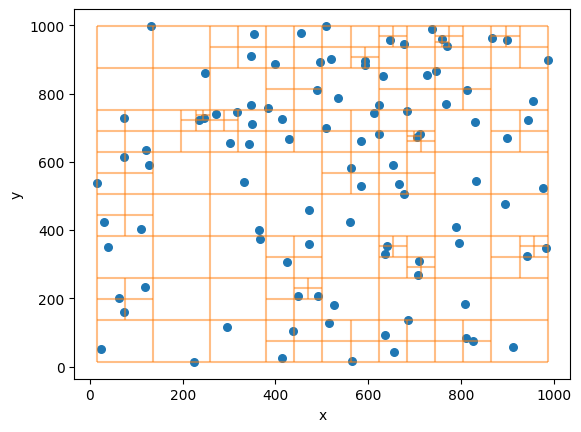

In [48]:
for i in UNIFORM:
    tree_uniform = VisualQuadTree(i)
    tree_uniform.visualize_creation().show()

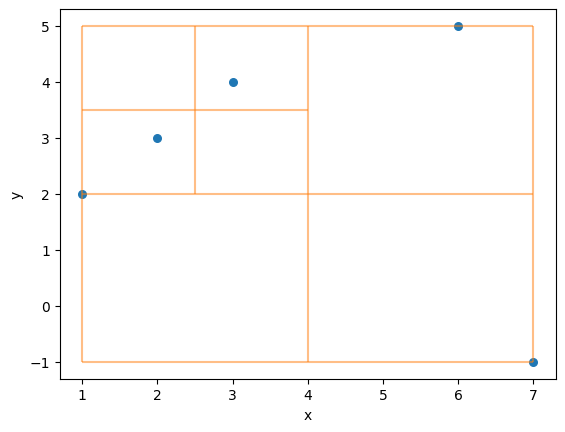

In [18]:
tree1.visualize_creation().show()

In [17]:
points = [(6, 0),
 (7, 1),
 (1, 0),
 (4, 5),
 (8, 1),
 (5, 4),
 (7, 6),
 (2, 2),
 (2, 3),
 (7, -1)]

In [18]:
tree = VisualQuadTree(points)

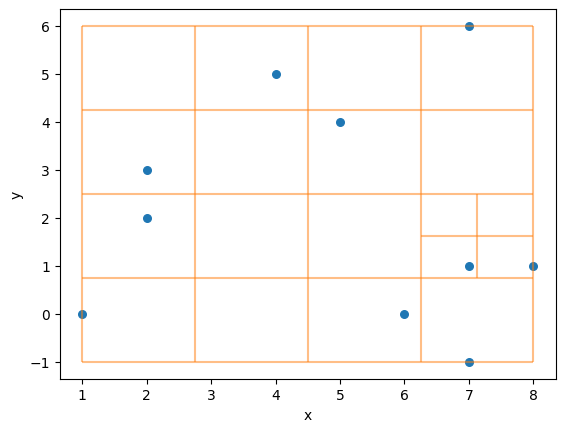

In [19]:
tree.visualize_creation().show()

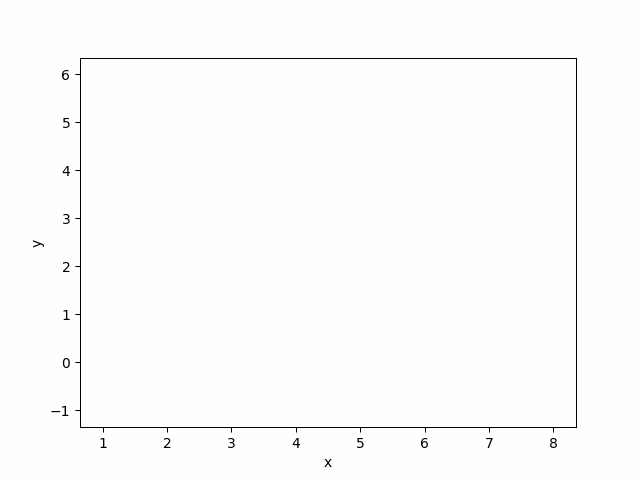

In [20]:
tree.visualize_creation().show_gif()

In [15]:
import sys
print(sys.getrecursionlimit())

3000


In [16]:
sys.setrecursionlimit(18000)

In [ ]:
point = generate_uniform_points(0, 10, 15)

In [24]:
pointsrect = [(9.362292572965451, 7.845976523554651),
 (2.2498656467033995, 5.77710150194604),
 (9.226951644037953, 5.214842806122364),
 (1.125286054901553, 1.098698756842429),
 (7.541056249773518, 1.6621090226701152),
 (0.590707793352726, 0.7591957120073856),
 (1.4214622668406651, 6.626082321340238),
 (3.1580076314925054, 7.870661410245006),
 (8.326534878665914, 7.552647097736454),
 (1.8522737071900819, 9.517284394889193),
 (6.553816256032173, 0.2138861216011767),
 (0.9950503571091962, 8.22163867704771),
 (5.774662896641863, 5.202053043600604),
 (4.549943972526816, 4.7104043890247915),
 (2.7427136641713714, 1.302108520273212)]

In [25]:
treeq = VisualQuadTree(pointsrect)

In [26]:
rect = Rectangle.from_tuples(xs=(2,6), ys=(4,7))
found, vis = treeq.search(rect, end_scene_persistence_duration=20)
found

[(5.774662896641863, 5.202053043600604),
 (2.2498656467033995, 5.77710150194604),
 (4.549943972526816, 4.7104043890247915)]

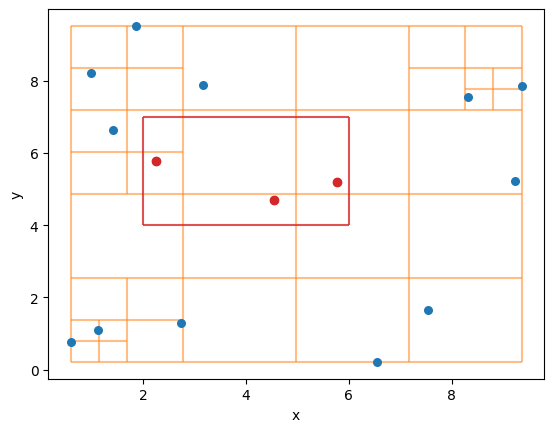

In [27]:
vis.show()

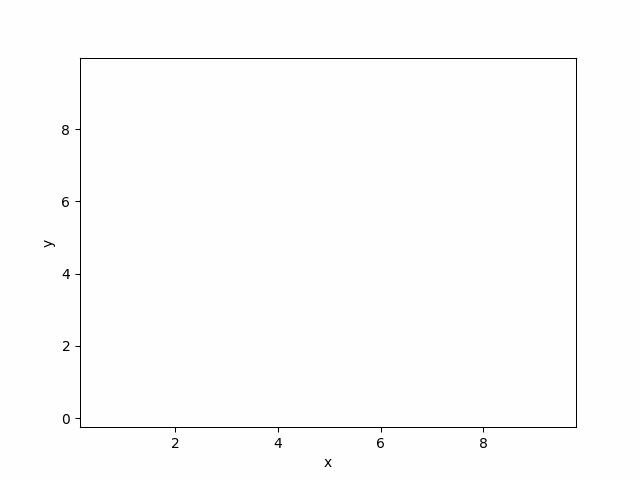

In [28]:
vis.show_gif(interval=200)

In [79]:
point = generate_uniform_points(0, 10, 100)

In [80]:
treeq1 = VisualQuadTree(pointsrect)

In [81]:
rect = Rectangle.from_tuples(xs=(2,6), ys=(4,7))
found, vis = treeq1.search(rect, end_scene_persistence_duration=20)
found

[(5.437579415579182, 6.710987754310251),
 (2.161092465211482, 5.978231044579742),
 (4.774240615800881, 6.897267721622677),
 (4.272093642950252, 6.315408617335738),
 (3.5032766671029547, 6.693194662011984),
 (2.7240075935236607, 5.91206013130659),
 (4.647669532188898, 5.976683225898276),
 (4.789310512389113, 5.751634154865436),
 (4.206052195609064, 6.074863350559294),
 (5.05369520551417, 4.999865620836298),
 (4.504090266725199, 5.007821330125721),
 (5.552079323216571, 4.529367557768664)]

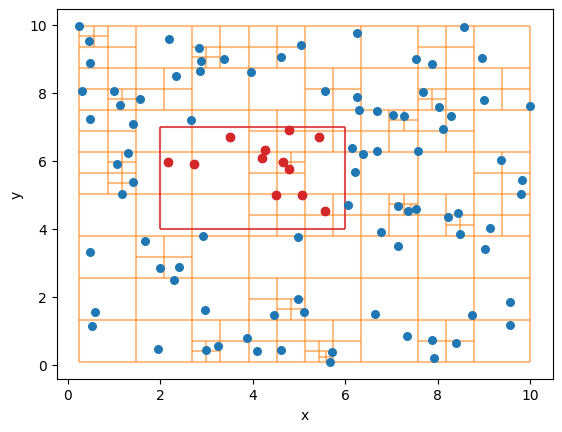

In [82]:
vis.show()

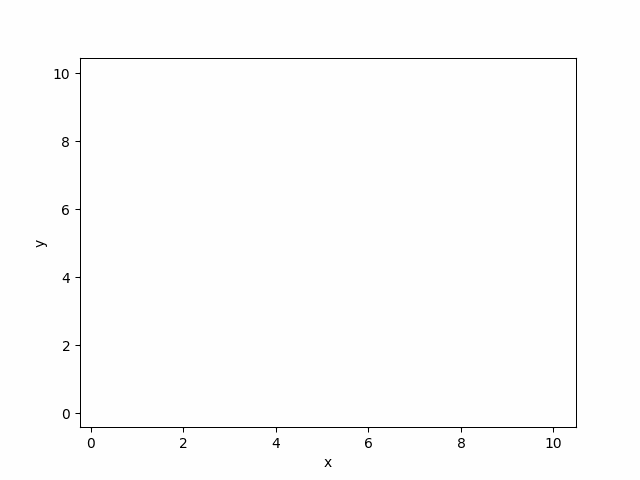

In [83]:
vis.show_gif(interval=200)